In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [2]:
import json

import torch
import tensorflow
import transformers

In [114]:
pd.set_option('display.max_columns', None)

# Import Data

In [115]:
train_avg = pd.read_csv('./data/train_avg.csv')
test_avg = pd.read_csv('./data/test_avg.csv')

train_doc = pd.read_csv('./data/train_doc.csv')
test_doc = pd.read_csv('./data/test_doc.csv')

valid_avg = pd.read_csv('./data/valid_avg.csv')
valid_doc = pd.read_csv('./data/valid_doc.csv')

data = pd.read_csv('./data/data_notembeded.csv')

df_bertweet = pd.read_csv('./data/df_bertweet.csv')
df_valid_bertweet = pd.read_csv('./data/df_valid_bertweet.csv')

In [116]:
for dataset in [train_avg, test_avg, train_doc, test_doc, valid_avg, valid_doc, df_bertweet, df_valid_bertweet, data]:
    dataset.drop(['text','text_token','urls', 'urls_expanded','user_url'], axis=1, inplace=True)

In [117]:
print("Shape of the Train and test data of Avg: {}/{}".format(train_avg.shape, test_avg.shape))
print("Shape of the Train and test data of Doc2vec: {}/{}".format(train_doc.shape, test_doc.shape))
print("\nShape of the validation data of Avg: {}".format(valid_avg.shape))
print("Shape of the validation data of Doc2vec: {}".format(valid_doc.shape))
print("\nShape of the data w/ BERTweet: {}".format(df_bertweet.shape))
print("\nShape of the validation data w/ BERTweet: {}".format(df_valid_bertweet.shape))

print("\nShape of the whole root tweet data w/o embedding: {}".format(data.shape))

Shape of the Train and test data of Avg: (4912, 329)/(890, 329)
Shape of the Train and test data of Doc2vec: (4912, 329)/(890, 329)

Shape of the validation data of Avg: (328, 329)
Shape of the validation data of Doc2vec: (328, 329)

Shape of the data w/ BERTweet: (5802, 797)

Shape of the validation data w/ BERTweet: (390, 797)

Shape of the whole root tweet data w/o embedding: (5802, 30)


In [118]:
train_y = train_avg.isRumor
test_y = test_avg.isRumor
valid_y = valid_avg.isRumor
df_bertweet_y = df_bertweet.isRumor
data_y = data.isRumor
df_valid_bertweet_y = df_valid_bertweet.isRumor
for dataset in [train_avg, test_avg, train_doc, test_doc, valid_avg, valid_doc, df_bertweet, df_valid_bertweet, data]:
    dataset.drop(['isRumor'], axis=1, inplace=True)

In [119]:
print(train_y.shape, test_y.shape, valid_y.shape, df_bertweet_y.shape, df_valid_bertweet_y.shape, data_y.shape)

(4912,) (890,) (328,) (5802,) (390,) (5802,)


In [120]:
train_avg_base = train_avg.drop(['hasURL', 'hasUserURL', 'isNotOnlyText', 'char_count'],axis=1)
test_avg_base = test_avg.drop(['hasURL', 'hasUserURL', 'isNotOnlyText', 'char_count'],axis=1)
valid_avg_base = valid_avg.drop(['hasURL', 'hasUserURL', 'isNotOnlyText', 'char_count'],axis=1)
train_doc_base = train_doc.drop(['hasURL', 'hasUserURL', 'isNotOnlyText', 'char_count'],axis=1)
test_doc_base = test_doc.drop(['hasURL', 'hasUserURL', 'isNotOnlyText', 'char_count'],axis=1)
valid_doc_base = valid_doc.drop(['hasURL', 'hasUserURL', 'isNotOnlyText', 'char_count'],axis=1)
bertweet_base = df_bertweet.drop(['hasURL', 'hasUserURL', 'isNotOnlyText', 'char_count'],axis=1)
bertweet_valid_base = df_valid_bertweet.drop(['hasURL', 'hasUserURL', 'isNotOnlyText', 'char_count'],axis=1)
data_base = data.drop(['hasURL', 'hasUserURL', 'isNotOnlyText', 'char_count'],axis=1)
# valid_doc_base = valid_doc.drop(['hasURL', 'hasUserURL', 'isNotOnlyText', 'char_count', ],axis=1)

In [121]:
train_novec= train_avg[['Noun', 'Verb', 'Adjective', 'Pronoun', 'FirstPersonPronoun', 'SecondPersonPronoun', 'ThirdPersonPronoun', 'Adverb', 'Numeral', 'Conjunction_inj', 'Particle', 'Determiner', 'Modal', 'Whs', 'word_count', 'has_question', 'has_exclaim', 'has_period', 'capital_ratio', 'tweet_count', 'listed_count', 'follow_ratio', 'age', 'verified','hasURL', 'hasUserURL', 'isNotOnlyText', 'char_count']]
test_novec= test_avg[['Noun', 'Verb', 'Adjective', 'Pronoun', 'FirstPersonPronoun', 'SecondPersonPronoun', 'ThirdPersonPronoun', 'Adverb', 'Numeral', 'Conjunction_inj', 'Particle', 'Determiner', 'Modal', 'Whs', 'word_count', 'has_question', 'has_exclaim', 'has_period', 'capital_ratio', 'tweet_count', 'listed_count', 'follow_ratio', 'age', 'verified', 'hasURL', 'hasUserURL', 'isNotOnlyText', 'char_count']]
valid_novec = valid_avg[['Noun', 'Verb', 'Adjective', 'Pronoun', 'FirstPersonPronoun', 'SecondPersonPronoun', 'ThirdPersonPronoun', 'Adverb', 'Numeral', 'Conjunction_inj', 'Particle', 'Determiner', 'Modal', 'Whs', 'word_count', 'has_question', 'has_exclaim', 'has_period', 'capital_ratio', 'tweet_count', 'listed_count', 'follow_ratio', 'age', 'verified', 'hasURL', 'hasUserURL', 'isNotOnlyText', 'char_count']]
# train_novec= train_avg_base[['Noun', 'Verb', 'Adjective', 'Pronoun', 'FirstPersonPronoun', 'SecondPersonPronoun', 'ThirdPersonPronoun', 'Adverb', 'Numeral', 'Conjunction_inj', 'Particle', 'Determiner', 'Modal', 'Whs', 'word_count', 'has_question', 'has_exclaim', 'has_period', 'capital_ratio', 'tweet_count', 'listed_count', 'follow_ratio', 'age', 'verified']]
# test_novec= test_avg_base[['Noun', 'Verb', 'Adjective', 'Pronoun', 'FirstPersonPronoun', 'SecondPersonPronoun', 'ThirdPersonPronoun', 'Adverb', 'Numeral', 'Conjunction_inj', 'Particle', 'Determiner', 'Modal', 'Whs', 'word_count', 'has_question', 'has_exclaim', 'has_period', 'capital_ratio', 'tweet_count', 'listed_count', 'follow_ratio', 'age', 'verified']]
# valid_novec = valid_avg_base[['Noun', 'Verb', 'Adjective', 'Pronoun', 'FirstPersonPronoun', 'SecondPersonPronoun', 'ThirdPersonPronoun', 'Adverb', 'Numeral', 'Conjunction_inj', 'Particle', 'Determiner', 'Modal', 'Whs', 'word_count', 'has_question', 'has_exclaim', 'has_period', 'capital_ratio', 'tweet_count', 'listed_count', 'follow_ratio', 'age', 'verified']]

In [122]:
def train_test(X_train, X_test, y_train, y_test, clf):
    clf.fit(X_train, y_train)
    result = clf.predict(X_test)
    print("Accuracy:",accuracy_score(result,y_test))
    print(classification_report(y_test, result))
    print(f1_score(y_test, result, average='macro'))


def valid(X_valid, y_valid, clf):
    result = clf.predict(X_valid)
    print("Accuracy:",accuracy_score(result,y_valid))
    print(classification_report(y_valid, result))

### Number of URls

In [123]:
urls_sum = pd.read_csv('/data./urls_sum.csv')
urls_sum_valid = pd.read_csv('/data./valid_urls_sum.csv')

In [133]:
df_bertweet.head(1)

,hasURL,hasUserURL,isNotOnlyText,Noun,Verb,Adjective,Pronoun,FirstPersonPronoun,SecondPersonPronoun,ThirdPersonPronoun,Adverb,Numeral,Conjunction_inj,Particle,Determiner,Modal,Whs,char_count,word_count,has_question,has_exclaim,has_period,capital_ratio,tweet_count,listed_count,follow_ratio,age,verified,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,NumOfUrls
0,1,1,1,6,3,0,0,0,0,0,0,0,2,0,0,0,0,88,11,0,0,1,0.159091,4.803286,3.855943,5.287349,2126,1,-0.050837,0.092732,0.114739,0.075394,0.107089,0.13905,0.07316,0.130306,0.228484,-0.100131,-0.014994,0.113855,-0.150934,0.122817,0.105345,0.282658,-0.009214,0.026026,0.384472,0.005275,-0.029484,0.008477,0.13608,0.086456,0.187912,-0.009612,0.067772,0.016709,0.259856,0.036181,-0.033826,-0.0338,0.127175,-0.034795,0.184054,-0.205514,0.036112,0.313101,0.028765,0.066649,-0.026885,-0.301041,0.025878,0.221337,0.413406,-0.046079,-0.008628,-0.089164,0.180499,-0.038341,0.062557,0.019168,0.294053,-0.127257,-0.072294,-0.165382,0.160989,0.319801,0.221671,-0.047767,0.043942,-0.09491,0.16816,-0.098562,0.235896,0.008319,0.179441,-0.042238,0.235

In [124]:
print(urls_sum.shape)
print(urls_sum_valid.shape)
print(df_bertweet.shape)
print(df_valid_bertweet.shape)
print(data.shape)

(5802, 1)
(390, 1)
(5802, 796)
(390, 796)
(5802, 29)


In [125]:
df_bertweet = pd.concat([df_bertweet,urls_sum],axis=1)
df_valid_bertweet = pd.concat([df_valid_bertweet,urls_sum_valid],axis=1)
data = pd.concat([data,urls_sum],axis=1)
print(df_bertweet.shape)
print(df_valid_bertweet.shape)
print(data.shape)

(5802, 797)
(390, 797)
(5802, 30)


# Classification

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
# define feature selection
fs = SelectKBest(score_func=f_classif, k=2)
# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

In [71]:
for i,col in enumerate(data):
    print("{}: {}".format(i, col))

0: hasURL
1: hasUserURL
2: isNotOnlyText
3: Noun
4: Verb
5: Adjective
6: Pronoun
7: FirstPersonPronoun
8: SecondPersonPronoun
9: ThirdPersonPronoun
10: Adverb
11: Numeral
12: Conjunction_inj
13: Particle
14: Determiner
15: Modal
16: Whs
17: char_count
18: word_count
19: has_question
20: has_exclaim
21: has_period
22: capital_ratio
23: tweet_count
24: listed_count
25: follow_ratio
26: age
27: verified
28: isRumor.1
29: NumOfUrls
30: NumOfUrls


Feature ranking:
1. feature 22: capital_ratio (0.073909)
2. feature 23: tweet_count (0.068439)
3. feature 25: follow_ratio (0.067538)
4. feature 24: listed_count (0.066843)
5. feature 26: age (0.063003)
6. feature 17: char_count (0.060206)
7. feature 18: word_count (0.059290)
8. feature 4: Verb (0.058110)
9. feature 3: Noun (0.054845)
10. feature 12: Conjunction_inj (0.050495)
11. feature 5: Adjective (0.049894)
12. feature 14: Determiner (0.045328)
13. feature 11: Numeral (0.042537)
14. feature 10: Adverb (0.035322)
15. feature 6: Pronoun (0.025884)
16. feature 7: FirstPersonPronoun (0.023385)
17. feature 27: verified (0.020702)
18. feature 16: Whs (0.020345)
19. feature 15: Modal (0.016057)
20. feature 9: ThirdPersonPronoun (0.015516)
21. feature 2: isNotOnlyText (0.014586)
22. feature 13: Particle (0.013632)
23. feature 0: hasURL (0.010724)
24. feature 21: has_period (0.010121)
25. feature 19: has_question (0.009321)
26. feature 8: SecondPersonPronoun (0.008906)
27. feature 28: NumO

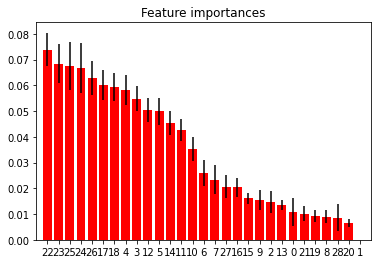

In [86]:
from sklearn.ensemble import ExtraTreesClassifier
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(data, data_y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(data.shape[1]):
    print("%d. feature %d: %s (%f)" % (f + 1, indices[f], data.columns[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(data.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(data.shape[1]), indices)
plt.xlim([-1, data.shape[1]])
plt.show()

## Basic Classifiers with Averaged Document Vector

## SVM
### Word2Vec Baseline Features

In [181]:
clf = make_pipeline((StandardScaler()), SVC(gamma='auto'))
train_test(train_avg_base, test_avg_base, train_y, test_y, clf)
valid(valid_avg_base, valid_y, clf)

Accuracy: 0.6898876404494382
              precision    recall  f1-score   support

           0       0.61      0.94      0.74       420
           1       0.89      0.47      0.62       470

    accuracy                           0.69       890
   macro avg       0.75      0.70      0.68       890
weighted avg       0.76      0.69      0.67       890

0.6778559400720772
Accuracy: 0.5030487804878049
              precision    recall  f1-score   support

           0       0.50      0.97      0.66       160
           1       0.69      0.05      0.10       168

    accuracy                           0.50       328
   macro avg       0.59      0.51      0.38       328
weighted avg       0.60      0.50      0.37       328



### Word2Vec Baseline Features (without word vectors)

In [182]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
train_test(train_novec, test_novec, train_y, test_y, clf)
valid(valid_novec, valid_y, clf)

Accuracy: 0.6067415730337079
              precision    recall  f1-score   support

           0       0.55      0.91      0.69       420
           1       0.81      0.33      0.47       470

    accuracy                           0.61       890
   macro avg       0.68      0.62      0.58       890
weighted avg       0.69      0.61      0.57       890

0.5791200298331611
Accuracy: 0.49085365853658536
              precision    recall  f1-score   support

           0       0.49      0.98      0.65       160
           1       0.57      0.02      0.05       168

    accuracy                           0.49       328
   macro avg       0.53      0.50      0.35       328
weighted avg       0.53      0.49      0.34       328



### Word2Vec Avg dataset *('hasURL', 'hasUserURL', 'isNotOnlyText', 'char_count')* are added

In [106]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
train_test(train_avg, test_avg, train_y, test_y, clf)
valid(valid_avg, valid_y, clf)

Accuracy: 0.6910112359550562
              precision    recall  f1-score   support

           0       0.61      0.94      0.74       420
           1       0.89      0.47      0.62       470

    accuracy                           0.69       890
   macro avg       0.75      0.70      0.68       890
weighted avg       0.76      0.69      0.68       890

Accuracy: 0.5030487804878049
              precision    recall  f1-score   support

           0       0.50      0.98      0.66       160
           1       0.73      0.05      0.09       168

    accuracy                           0.50       328
   macro avg       0.61      0.51      0.37       328
weighted avg       0.61      0.50      0.37       328



### Doc2Vec dataset

In [109]:
clf = make_pipeline((StandardScaler()), SVC(gamma='auto'))
train_test(train_doc_base, test_doc_base, train_y, test_y, clf)
valid(valid_doc_base, valid_y, clf)

Accuracy: 0.4730337078651685
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       420
           1       0.60      0.01      0.01       470

    accuracy                           0.47       890
   macro avg       0.54      0.50      0.33       890
weighted avg       0.54      0.47      0.31       890

Accuracy: 0.4878048780487805
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       160
           1       0.00      0.00      0.00       168

    accuracy                           0.49       328
   macro avg       0.24      0.50      0.33       328
weighted avg       0.24      0.49      0.32       328



In [110]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
train_test(train_doc, test_doc, train_y, test_y, clf)
valid(valid_doc, valid_y, clf)

Accuracy: 0.4752808988764045
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       420
           1       0.71      0.01      0.02       470

    accuracy                           0.48       890
   macro avg       0.59      0.50      0.33       890
weighted avg       0.60      0.48      0.31       890

Accuracy: 0.4878048780487805
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       160
           1       0.00      0.00      0.00       168

    accuracy                           0.49       328
   macro avg       0.24      0.50      0.33       328
weighted avg       0.24      0.49      0.32       328



### BERTweet

In [126]:
clf = make_pipeline((StandardScaler()), SVC(gamma='auto'))
train_test(bertweet_base, bertweet_valid_base, df_bertweet_y, df_valid_bertweet_y, clf)
# valid(valid_avg_base, valid_y, clf)

Accuracy: 0.517948717948718
              precision    recall  f1-score   support

           0       0.50      0.99      0.67       189
           1       0.88      0.07      0.14       201

    accuracy                           0.52       390
   macro avg       0.69      0.53      0.40       390
weighted avg       0.70      0.52      0.39       390

0.40154755297267297


In [127]:
# 'hasURL', 'hasUserURL', 'isNotOnlyText', 'char_count', 'NumOfURLs'
clf = make_pipeline((StandardScaler()), SVC(gamma='auto'))
train_test(df_bertweet, df_valid_bertweet, df_bertweet_y, df_valid_bertweet_y, clf)
# valid(valid_avg_base, valid_y, clf)

Accuracy: 0.5205128205128206
              precision    recall  f1-score   support

           0       0.50      0.98      0.67       189
           1       0.85      0.08      0.15       201

    accuracy                           0.52       390
   macro avg       0.68      0.53      0.41       390
weighted avg       0.68      0.52      0.40       390

0.40966010733452596


## Naive Bayes

In [112]:
from sklearn.naive_bayes import GaussianNB

In [113]:
clf = make_pipeline((StandardScaler()), GaussianNB())
train_test(train_avg_base, test_avg_base, train_y, test_y, clf)
valid(valid_avg_base, valid_y, clf)

Accuracy: 0.7235955056179775
              precision    recall  f1-score   support

           0       0.67      0.83      0.74       420
           1       0.80      0.63      0.71       470

    accuracy                           0.72       890
   macro avg       0.74      0.73      0.72       890
weighted avg       0.74      0.72      0.72       890

Accuracy: 0.524390243902439
              precision    recall  f1-score   support

           0       0.51      0.96      0.66       160
           1       0.75      0.11      0.19       168

    accuracy                           0.52       328
   macro avg       0.63      0.53      0.43       328
weighted avg       0.63      0.52      0.42       328



In [116]:
clf = make_pipeline((StandardScaler()), GaussianNB())
train_test(train_avg_novec, test_avg_novec, train_y, test_y, clf)
valid(valid_avg_novec, valid_y, clf)

Accuracy: 0.6640449438202247
              precision    recall  f1-score   support

           0       0.69      0.52      0.59       420
           1       0.65      0.79      0.71       470

    accuracy                           0.66       890
   macro avg       0.67      0.66      0.65       890
weighted avg       0.67      0.66      0.66       890

Accuracy: 0.5457317073170732
              precision    recall  f1-score   support

           0       0.52      0.81      0.63       160
           1       0.62      0.30      0.40       168

    accuracy                           0.55       328
   macro avg       0.57      0.55      0.52       328
weighted avg       0.57      0.55      0.51       328



In [115]:
clf = make_pipeline((StandardScaler()), GaussianNB())
train_test(train_avg, test_avg, train_y, test_y, clf)
valid(valid_avg, valid_y, clf)

Accuracy: 0.7235955056179775
              precision    recall  f1-score   support

           0       0.67      0.83      0.74       420
           1       0.80      0.63      0.71       470

    accuracy                           0.72       890
   macro avg       0.74      0.73      0.72       890
weighted avg       0.74      0.72      0.72       890

Accuracy: 0.524390243902439
              precision    recall  f1-score   support

           0       0.51      0.96      0.66       160
           1       0.75      0.11      0.19       168

    accuracy                           0.52       328
   macro avg       0.63      0.53      0.43       328
weighted avg       0.63      0.52      0.42       328



## Logistic Regression

In [117]:
from sklearn.linear_model import LogisticRegression

In [118]:
clf = make_pipeline((StandardScaler()), LogisticRegression())
train_test(train_avg_base, test_avg_base, train_y, test_y, clf)
valid(valid_avg_base, valid_y, clf)

Accuracy: 0.648314606741573
              precision    recall  f1-score   support

           0       0.58      0.95      0.72       420
           1       0.89      0.38      0.53       470

    accuracy                           0.65       890
   macro avg       0.73      0.66      0.63       890
weighted avg       0.74      0.65      0.62       890

Accuracy: 0.5274390243902439
              precision    recall  f1-score   support

           0       0.51      0.93      0.66       160
           1       0.69      0.14      0.24       168

    accuracy                           0.53       328
   macro avg       0.60      0.54      0.45       328
weighted avg       0.60      0.53      0.44       328



In [121]:
clf = make_pipeline((StandardScaler()), LogisticRegression())
train_test(train_avg_novec, test_avg_novec, train_y, test_y, clf)
valid(valid_avg_novec, valid_y, clf)

Accuracy: 0.5853932584269663
              precision    recall  f1-score   support

           0       0.54      0.90      0.67       420
           1       0.78      0.30      0.43       470

    accuracy                           0.59       890
   macro avg       0.66      0.60      0.55       890
weighted avg       0.66      0.59      0.55       890

Accuracy: 0.4969512195121951
              precision    recall  f1-score   support

           0       0.49      0.96      0.65       160
           1       0.60      0.05      0.10       168

    accuracy                           0.50       328
   macro avg       0.55      0.51      0.37       328
weighted avg       0.55      0.50      0.37       328



In [122]:
clf = make_pipeline((StandardScaler()), LogisticRegression())
train_test(train_avg, test_avg, train_y, test_y, clf)
valid(valid_avg, valid_y, clf)

Accuracy: 0.6393258426966292
              precision    recall  f1-score   support

           0       0.57      0.93      0.71       420
           1       0.86      0.38      0.52       470

    accuracy                           0.64       890
   macro avg       0.72      0.65      0.62       890
weighted avg       0.73      0.64      0.61       890

Accuracy: 0.524390243902439
              precision    recall  f1-score   support

           0       0.51      0.93      0.65       160
           1       0.67      0.14      0.24       168

    accuracy                           0.52       328
   macro avg       0.59      0.53      0.45       328
weighted avg       0.59      0.52      0.44       328



### Doc2Vec

In [192]:
clf = make_pipeline(StandardScaler(), LogisticRegression())
train_test(train_doc_base, test_doc_base, train_y, test_y, clf)
valid(valid_doc_base, valid_y, clf)

Accuracy: 0.5483146067415731
              precision    recall  f1-score   support

           0       0.51      0.82      0.63       420
           1       0.66      0.30      0.42       470

    accuracy                           0.55       890
   macro avg       0.58      0.56      0.52       890
weighted avg       0.59      0.55      0.52       890

0.5237829031433683
Accuracy: 0.5121951219512195
              precision    recall  f1-score   support

           0       0.50      0.86      0.63       160
           1       0.57      0.18      0.28       168

    accuracy                           0.51       328
   macro avg       0.54      0.52      0.46       328
weighted avg       0.54      0.51      0.45       328



In [ ]:
clf = make_pipeline((StandardScaler()), LogisticRegression())
train_test(train_doc_nobase, test_avg, train_y, test_y, clf)
valid(valid_avg, valid_y, clf)

### Bertweet

In [215]:
clf = make_pipeline(StandardScaler(), LogisticRegression())
train_test(bertweet_base, bertweet_valid_base, df_bertweet_y, df_valid_bertweet_y, clf)
# valid(valid_avg_base, valid_y, clf)

Accuracy: 0.5538461538461539
              precision    recall  f1-score   support

           0       0.52      0.87      0.65       189
           1       0.68      0.25      0.37       201

    accuracy                           0.55       390
   macro avg       0.60      0.56      0.51       390
weighted avg       0.60      0.55      0.51       390

0.5121635610766045


## Random Forest

In [129]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [130]:
clf = make_pipeline((StandardScaler()), RandomForestClassifier(max_depth=5, random_state=0))
train_test(train_avg_base, test_avg_base, train_y, test_y, clf)
valid(valid_avg_base, valid_y, clf)

Accuracy: 0.7179775280898877
              precision    recall  f1-score   support

           0       0.64      0.92      0.75       420
           1       0.88      0.54      0.67       470

    accuracy                           0.72       890
   macro avg       0.76      0.73      0.71       890
weighted avg       0.77      0.72      0.71       890

0.7117321492401337
Accuracy: 0.5030487804878049
              precision    recall  f1-score   support

           0       0.50      0.97      0.66       160
           1       0.69      0.05      0.10       168

    accuracy                           0.50       328
   macro avg       0.59      0.51      0.38       328
weighted avg       0.60      0.50      0.37       328



In [132]:
clf = make_pipeline((StandardScaler()), RandomForestClassifier(max_depth=5, random_state=0))
train_test(train_doc_base, test_doc_base, train_y, test_y, clf)
valid(valid_doc_base, valid_y, clf)

Accuracy: 0.49325842696629213
              precision    recall  f1-score   support

           0       0.48      1.00      0.65       420
           1       1.00      0.04      0.08       470

    accuracy                           0.49       890
   macro avg       0.74      0.52      0.36       890
weighted avg       0.76      0.49      0.35       890

0.36418400789483274
Accuracy: 0.4878048780487805
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       160
           1       0.00      0.00      0.00       168

    accuracy                           0.49       328
   macro avg       0.24      0.50      0.33       328
weighted avg       0.24      0.49      0.32       328



In [205]:
clf = make_pipeline( RandomForestClassifier())
train_test(bertweet_base, bertweet_valid_base, df_bertweet_y, df_valid_bertweet_y, clf)

Accuracy: 0.48717948717948717
              precision    recall  f1-score   support

           0       0.49      1.00      0.65       189
           1       1.00      0.00      0.01       201

    accuracy                           0.49       390
   macro avg       0.74      0.50      0.33       390
weighted avg       0.75      0.49      0.32       390

0.3319401144266676


---